# Multi-Layer Perceptron, MNIST

In [0]:
import torch
import numpy as np

In [0]:
from torchvision import datasets
import torchvision.transforms as transform
from torch.utils.data.sampler import SubsetRandomSampler

# Load data

In [0]:
# Number of subprocesses for dataloading
num_workers = 0

# Batch size
batch_size = 20

# convert data to tensor
transform = transform.ToTensor()

# Training and testing datasets
train_data = datasets.MNIST(root="data", train=True, download=True, transform=transform)

test_data = datasets.MNIST(root="data", train=False, download=True, transform=transform)

# percentage of training set to use as validation
valid_size = 0.2

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# Prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)


# Visualize

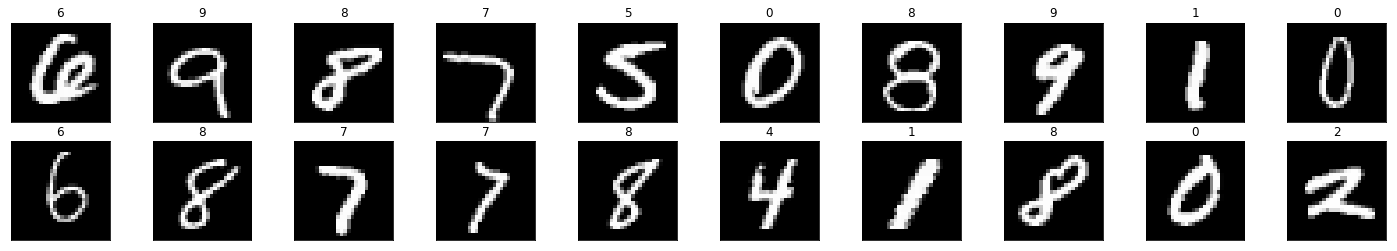

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

# data
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  
  ax.imshow(np.squeeze(images[idx]), cmap="gray")
  
  ax.set_title(str(labels[idx].item()))

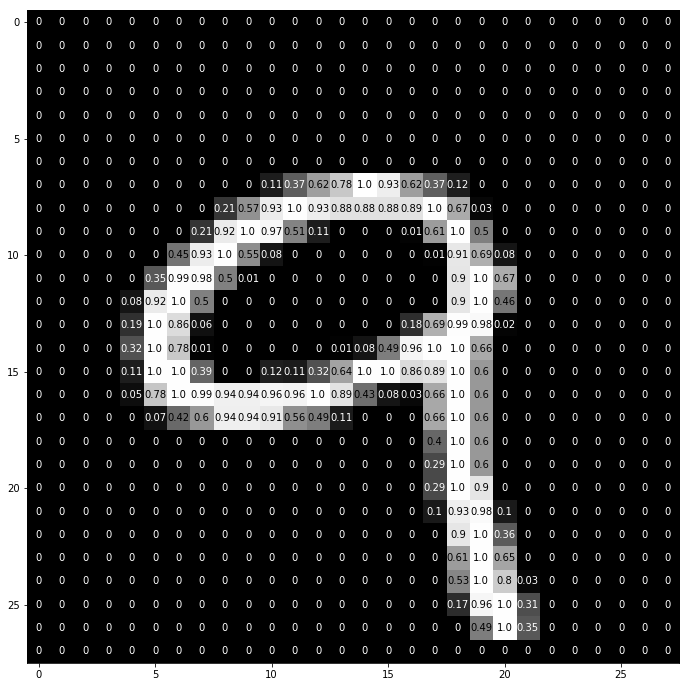

In [27]:
img = np.squeeze(images[1])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

# Network Architecture

In [28]:
import torch.nn as nn
import torch.nn.functional as F

class Network(nn.Module):
  def __init__(self):
    super().__init__()
    
    self.fc1 = nn.Linear(784, 512)
    self.fc2 = nn.Linear(512, 512)
    self.fc3 = nn.Linear(512, 10)
    
    # Dropout with 20% probability
    self.dropout = nn.Dropout(0.2)
    
  def forward(self, x):
    x = x.view(-1, 784)
    
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = F.relu(self.fc2(x))
    x = self.dropout(x)
    x = F.log_softmax(self.fc3(x), dim=1)
    
    return x
  
model = Network()
model

Network(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
)

In [0]:
# loss function
criterion = nn.NLLLoss()

# Stochastic Gradient Descent
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# Train

In [35]:
epochs = 20

valid_loss_min = np.Inf

for e in range(epochs):
  train_loss = 0.0
  valid_loss = 0.0
  
  # TRAINING
  model.train()
  for images, labels in train_loader:
    # clear the gradients
    optimizer.zero_grad()
    
    #output
    log_ps = model(images)
    
    # loss
    loss = criterion(log_ps, labels)   
    
    # backpass
    loss.backward()
    
    # weight update
    optimizer.step()
    
    #update total loss
    train_loss += loss.item()
    
  # VALIDATE
  model.eval()
  
  for images, labels in valid_loader:
    log_ps = model(images)
    loss = criterion(log_ps, labels)
    
    valid_loss += loss.item()
    
  # print training/validation statistics 
  # calculate average loss over an epoch
  train_loss = train_loss/len(train_loader.sampler)
  valid_loss = valid_loss/len(valid_loader.sampler)
    
  print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        e+1, 
        train_loss,
        valid_loss
        ))
    
  # save model if validation loss has decreased
  if valid_loss <= valid_loss_min:
      print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
      valid_loss_min,
      valid_loss))
      torch.save(model.state_dict(), 'model.pt')
      valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.017932 	Validation Loss: 0.014356
Validation loss decreased (inf --> 0.014356).  Saving model ...
Epoch: 2 	Training Loss: 0.014272 	Validation Loss: 0.011905
Validation loss decreased (0.014356 --> 0.011905).  Saving model ...
Epoch: 3 	Training Loss: 0.011948 	Validation Loss: 0.009961
Validation loss decreased (0.011905 --> 0.009961).  Saving model ...
Epoch: 4 	Training Loss: 0.010098 	Validation Loss: 0.008786
Validation loss decreased (0.009961 --> 0.008786).  Saving model ...
Epoch: 5 	Training Loss: 0.008851 	Validation Loss: 0.007817
Validation loss decreased (0.008786 --> 0.007817).  Saving model ...
Epoch: 6 	Training Loss: 0.007707 	Validation Loss: 0.006839
Validation loss decreased (0.007817 --> 0.006839).  Saving model ...
Epoch: 7 	Training Loss: 0.006963 	Validation Loss: 0.006265
Validation loss decreased (0.006839 --> 0.006265).  Saving model ...
Epoch: 8 	Training Loss: 0.006154 	Validation Loss: 0.005852
Validation loss decreased (0.00626

In [37]:
model.load_state_dict(torch.load('model.pt'))


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

# TEST

In [38]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for evaluation

for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.068311

Test Accuracy of     0: 99% (972/980)
Test Accuracy of     1: 99% (1126/1135)
Test Accuracy of     2: 97% (1006/1032)
Test Accuracy of     3: 98% (996/1010)
Test Accuracy of     4: 97% (957/982)
Test Accuracy of     5: 97% (874/892)
Test Accuracy of     6: 97% (937/958)
Test Accuracy of     7: 96% (996/1028)
Test Accuracy of     8: 96% (944/974)
Test Accuracy of     9: 96% (976/1009)

Test Accuracy (Overall): 97% (9784/10000)
